# Dataset loading

In [47]:
import sys
import os
import importlib
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Add project to path so we can import our modules
sys.path.append(os.path.abspath(".."))

# Import functionality from our source code
import src.data_loading.data_loader as data_loader
importlib.reload(data_loader)
from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

# Loading intermediate dataset
script_dir  = pathlib.Path.cwd()              
project_root = script_dir.parent
file_path = project_root / 'data' / 'processed' / 'initial_processed_dataset_25k_rows.csv'

df = load_data(str(file_path))

Loading data from c:\Users\Utente\Desktop\STUDIO\LUISS\ANNO_3\Advanced_Coding\Credit_Score_Classification\data\processed\intermediate_dataset.csv
Loaded dataset with 25000 rows and 32 columns


# Default Outliers Handling and Features Encoding

In [48]:
# Import your custom classes
from src.preprocessing.outliers.outliers_handler import OutlierHandler
from src.preprocessing.categorical.feature_encoder import FeatureEncoder

# Define encoding map with default strategies
encoding_map = {
    'Month': 'ordinal',
    'City': 'one-hot',
    'Street': 'frequency',
    'Occupation': 'frequency',  # Using default strategy for features with alternatives
    'Credit_Mix': 'ordinal',
    'Payment_of_Min_Amount': 'one-hot'  # Using default strategy for features with alternatives
}

# Define encoding parameters
encoding_params = {
    'Month': {
        'order_map': {
            'January': 1, 'February': 2, 'March': 3, 'April': 4, 
            'May': 5, 'June': 6, 'July': 7, 'August': 8, 
            'September': 9, 'October': 10, 'November': 11, 'December': 12, 
            'Unknown': 0
        }
    },
    'Credit_Mix': {
        'order_map': {'Bad': 1, 'Standard': 2, 'Good': 3, '_': 0, 'Unknown': 0}
    }
}

# Initialize the transformers with default parameters
outlier_handler = OutlierHandler(strategy='clip', z_thresh=3.0)

# Apply transformations (assuming df is your intermediate dataset)
X = df # I did not drop the target beceause it is necessary for the target encoding in both X and y
y = df['Credit_Score']

# Step 1: Handle outliers on numerical features first
# Get only the numerical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numerical = X[numerical_columns].copy()

# Fit and transform outlier handler on numerical data only
outlier_handler.fit(X_numerical)
X_numerical_processed = outlier_handler.transform(X_numerical)

# Recombine with categorical data
X_with_outliers_handled = X.copy()
X_with_outliers_handled[numerical_columns] = X_numerical_processed

# Step 2: Now apply feature encoding
feature_encoder = FeatureEncoder(encoding_map=encoding_map, encoding_params=encoding_params)
feature_encoder.fit(X_with_outliers_handled, y)  # Need y for target encoding
X_processed = feature_encoder.transform(X_with_outliers_handled)

# Now X_processed is ready for your exploratory analysis

#  

# Correlations Analysis

CORRELATION ANALYSIS REPORT


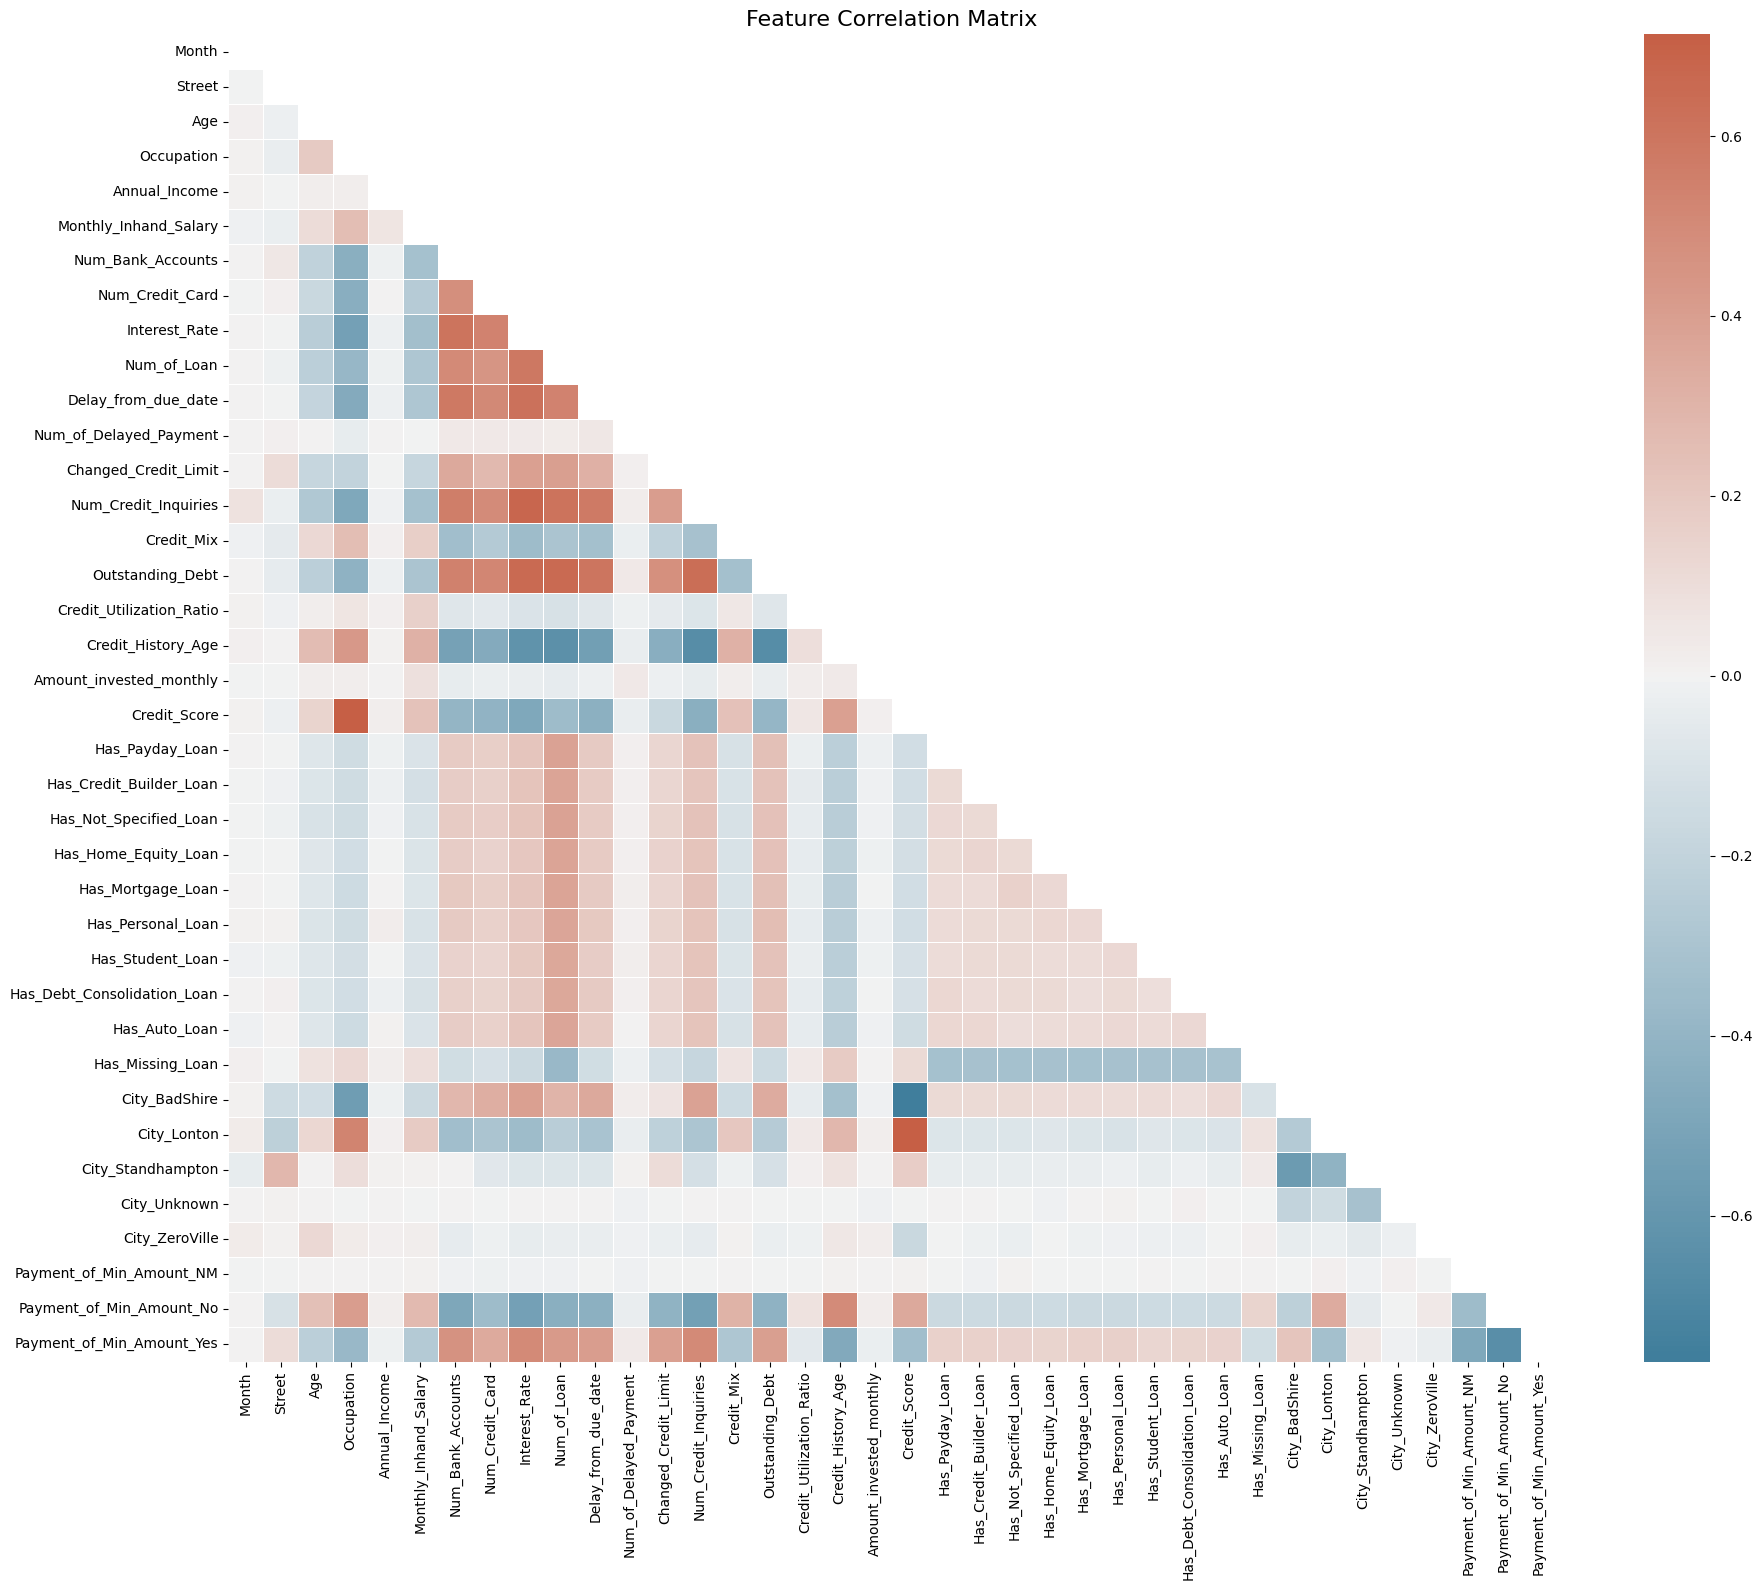


1. CORRELATION WITH TARGET
--------------------------------------------------
Strong positive correlation (>0.5):
  City_Lonton: 0.7131
  Occupation: 0.7088

Moderate positive correlation (0.3-0.5):
  Credit_History_Age: 0.3913
  Payment_of_Min_Amount_No: 0.3534

Weak positive correlation (0.1-0.3):
  Credit_Mix: 0.2299
  Monthly_Inhand_Salary: 0.2253
  City_Standhampton: 0.1736
  Age: 0.1446
  Has_Missing_Loan: 0.1144

Strong negative correlation (<-0.5):
  City_BadShire: -0.7622

Moderate negative correlation (-0.3 to -0.5):
  Payment_of_Min_Amount_Yes: -0.3375
  Num_of_Loan: -0.3504
  Outstanding_Debt: -0.3877
  Num_Bank_Accounts: -0.3939
  Num_Credit_Card: -0.4102
  Delay_from_due_date: -0.4287
  Num_Credit_Inquiries: -0.4359
  Interest_Rate: -0.4823

Weak negative correlation (-0.1 to -0.3):
  Has_Debt_Consolidation_Loan: -0.1143
  Has_Student_Loan: -0.1167
  Has_Home_Equity_Loan: -0.1239
  Has_Not_Specified_Loan: -0.1255
  Has_Credit_Builder_Loan: -0.1296
  Has_Personal_Loan: -0

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

def correlation_analysis(df, target_column, plot=True):
    """
    Perform comprehensive correlation analysis on the dataset
    
    Parameters:
    -----------
    df : pandas DataFrame
        Processed dataset with all features
    target_column : str
        Name of the target column
    plot : bool, default=True
        Whether to generate correlation heatmap
        
    Returns:
    --------
    dict
        Dictionary containing the analysis results
    """
    print("=" * 80)
    print("CORRELATION ANALYSIS REPORT")
    print("=" * 80)
    
    # Calculate correlation matrix
    correlation_matrix = df.corr()
    
    # Plot if requested
    if plot:
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, 
                    center=0, square=True, linewidths=.5)
        plt.title('Feature Correlation Matrix', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # 1. Target Correlation Analysis
    # Professional thresholds based on Cohen's standards
    # (widely used in statistics for effect size interpretation)
    target_correlation = correlation_matrix[target_column].drop(target_column).sort_values(ascending=False)
    
    strong_pos_corr = target_correlation[target_correlation > 0.5]
    moderate_pos_corr = target_correlation[(target_correlation > 0.3) & (target_correlation <= 0.5)]
    weak_pos_corr = target_correlation[(target_correlation > 0.1) & (target_correlation <= 0.3)]
    
    strong_neg_corr = target_correlation[target_correlation < -0.5]
    moderate_neg_corr = target_correlation[(target_correlation < -0.3) & (target_correlation >= -0.5)]
    weak_neg_corr = target_correlation[(target_correlation < -0.1) & (target_correlation >= -0.3)]
    
    no_corr = target_correlation[(target_correlation >= -0.1) & (target_correlation <= 0.1)]
    
    print("\n1. CORRELATION WITH TARGET")
    print("-" * 50)
    print(f"Strong positive correlation (>0.5):")
    for feature, corr in strong_pos_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nModerate positive correlation (0.3-0.5):")
    for feature, corr in moderate_pos_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nWeak positive correlation (0.1-0.3):")
    for feature, corr in weak_pos_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nStrong negative correlation (<-0.5):")
    for feature, corr in strong_neg_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nModerate negative correlation (-0.3 to -0.5):")
    for feature, corr in moderate_neg_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nWeak negative correlation (-0.1 to -0.3):")
    for feature, corr in weak_neg_corr.items():
        print(f"  {feature}: {corr:.4f}")
        
    print(f"\nNo meaningful correlation (-0.1 to 0.1):")
    for feature, corr in no_corr.items():
        print(f"  {feature}: {corr:.4f}")
    
    # 2. Multicollinearity Analysis - Professional threshold of 0.7
    # (widely accepted threshold in statistics for problematic multicollinearity)
    print("\n\n2. MULTICOLLINEARITY ANALYSIS")
    print("-" * 50)
    
    # Remove target column from multicollinearity analysis
    corr_matrix_no_target = correlation_matrix.drop(target_column, axis=1).drop(target_column, axis=0)
    
    # Find pairs with high correlation
    high_corr_pairs = []
    
    for i, j in combinations(corr_matrix_no_target.columns, 2):
        corr_value = abs(corr_matrix_no_target.loc[i, j])
        if corr_value > 0.7:  # Professional threshold for concerning multicollinearity
            corr_actual = corr_matrix_no_target.loc[i, j]  # Get actual value with sign
            target_corr_i = abs(correlation_matrix.loc[i, target_column])
            target_corr_j = abs(correlation_matrix.loc[j, target_column])
            high_corr_pairs.append((i, j, corr_actual, target_corr_i, target_corr_j))
    
    if high_corr_pairs:
        print("Highly correlated feature pairs (|r| > 0.7):")
        for i, j, corr, corr_i, corr_j in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            keep = i if corr_i >= corr_j else j
            drop = j if corr_i >= corr_j else i
            print(f"  {i} and {j}: r = {corr:.4f}")
            print(f"    - {i} correlation with target: {corr_i:.4f}")
            print(f"    - {j} correlation with target: {corr_j:.4f}")
            print(f"    - Recommendation: Keep '{keep}' (stronger target correlation) and consider dropping '{drop}'")
    else:
        print("No highly correlated pairs found (all |r| <= 0.7)")
    
    # 3. Correlation Clusters Analysis
    print("\n\n3. CORRELATION CLUSTERS ANALYSIS")
    print("-" * 50)
    
    # Convert correlation matrix to distance matrix for clustering
    dist_matrix = 1 - abs(corr_matrix_no_target)
    
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import squareform
    
    # Convert to condensed distance matrix for linkage function
    condensed_dist = squareform(dist_matrix)
    
    # Hierarchical clustering
    Z = hierarchy.linkage(condensed_dist, 'ward')
    
    # Cut the tree to get clusters (adjust threshold as needed)
    clusters = hierarchy.fcluster(Z, t=0.5, criterion='distance')
    
    # Create a mapping of features to their cluster
    feature_clusters = {}
    for feature, cluster_id in zip(corr_matrix_no_target.columns, clusters):
        if cluster_id not in feature_clusters:
            feature_clusters[cluster_id] = []
        feature_clusters[cluster_id].append(feature)
    
    # Print clusters and their features
    print(f"Identified {len(feature_clusters)} feature clusters:")
    for cluster_id, features in feature_clusters.items():
        if len(features) > 1:  # Only show clusters with multiple features
            print(f"  Cluster {cluster_id}: {features}")
            
            # Get average target correlation for features in this cluster
            target_corrs = [correlation_matrix.loc[feature, target_column] for feature in features]
            avg_target_corr = sum(abs(c) for c in target_corrs) / len(target_corrs)
            
            # Find feature with highest target correlation
            best_feature = features[np.argmax([abs(correlation_matrix.loc[f, target_column]) for f in features])]
            
            print(f"    - Average target correlation: {avg_target_corr:.4f}")
            print(f"    - Best feature in cluster: {best_feature} " +
                  f"(r = {correlation_matrix.loc[best_feature, target_column]:.4f})")
            
            if len(features) > 3:
                # For large clusters, consider keeping only the best feature
                print(f"    - Recommendation: Consider keeping only {best_feature} from this cluster")
    
    # Identify features with no strong correlations to any other feature
    isolated_features = []
    for feature in corr_matrix_no_target.columns:
        # Check if this feature has no correlation above 0.3 with any other feature
        max_corr = max(abs(corr_matrix_no_target[feature].drop(feature)))
        if max_corr < 0.3:
            isolated_features.append((feature, correlation_matrix.loc[feature, target_column], max_corr))
    
    if isolated_features:
        print("\nFeatures with no meaningful correlation to other features (max |r| < 0.3):")
        for feature, target_corr, max_corr in isolated_features:
            print(f"  {feature}:")
            print(f"    - Correlation with target: {target_corr:.4f}")
            print(f"    - Max correlation with any other feature: {max_corr:.4f}")
            if abs(target_corr) < 0.3:
                print(f"    - Recommendation: Consider investigating with non-linear methods or dropping")
            else:
                print(f"    - Recommendation: Keep (unique information with reasonable target correlation)")
    
    # Return results for further use
    return {
        'target_correlation': target_correlation,
        'high_correlation_pairs': high_corr_pairs,
        'feature_clusters': feature_clusters,
        'isolated_features': isolated_features
    }

# Usage example:
correlation_analysis_results = correlation_analysis(X_processed, 'Credit_Score')

# Feature importance Analysis

FEATURE IMPORTANCE ANALYSIS REPORT

1. RANDOM FOREST IMPORTANCE
--------------------------------------------------


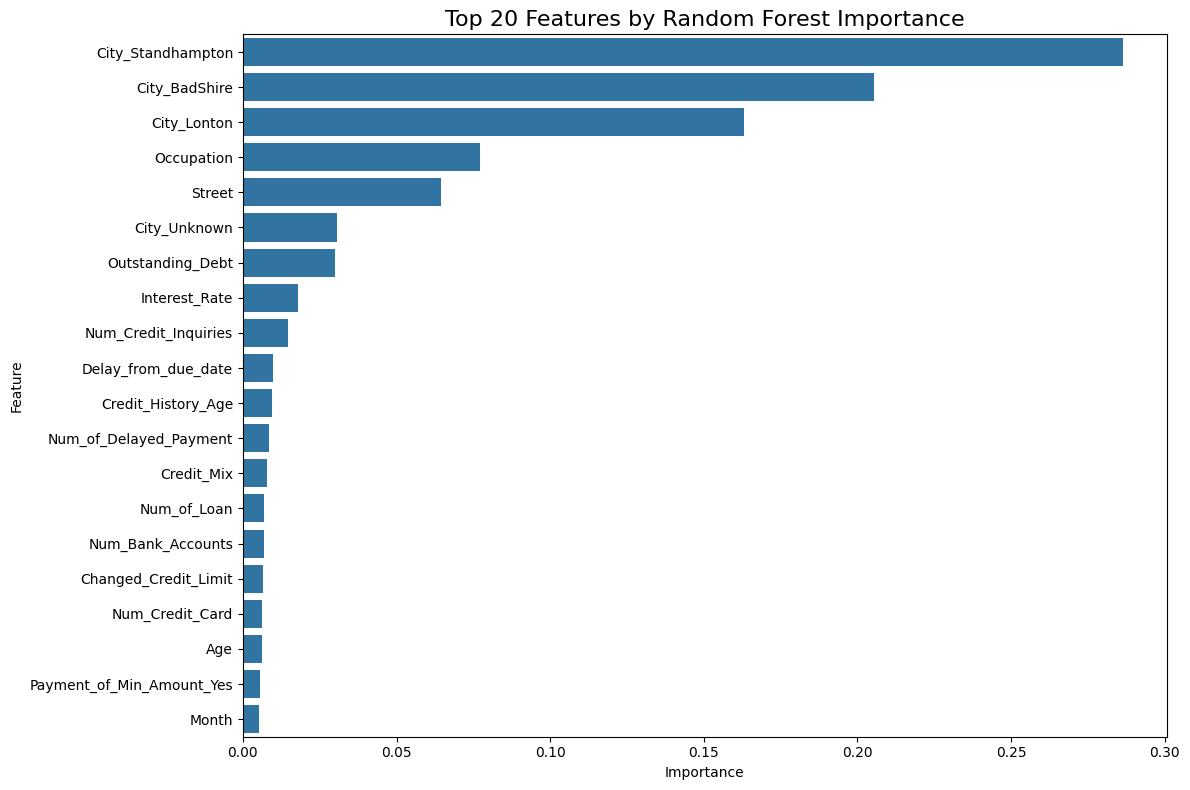

Identified importance 'cliff' after feature #3: City_Lonton
Importance value at cliff: 0.1630
Recommended feature count: 3

Top features above the cliff:
  1. City_Standhampton (Importance: 0.2864)
  2. City_BadShire (Importance: 0.2053)
  3. City_Lonton (Importance: 0.1630)


2. PERMUTATION IMPORTANCE (more robust)
--------------------------------------------------


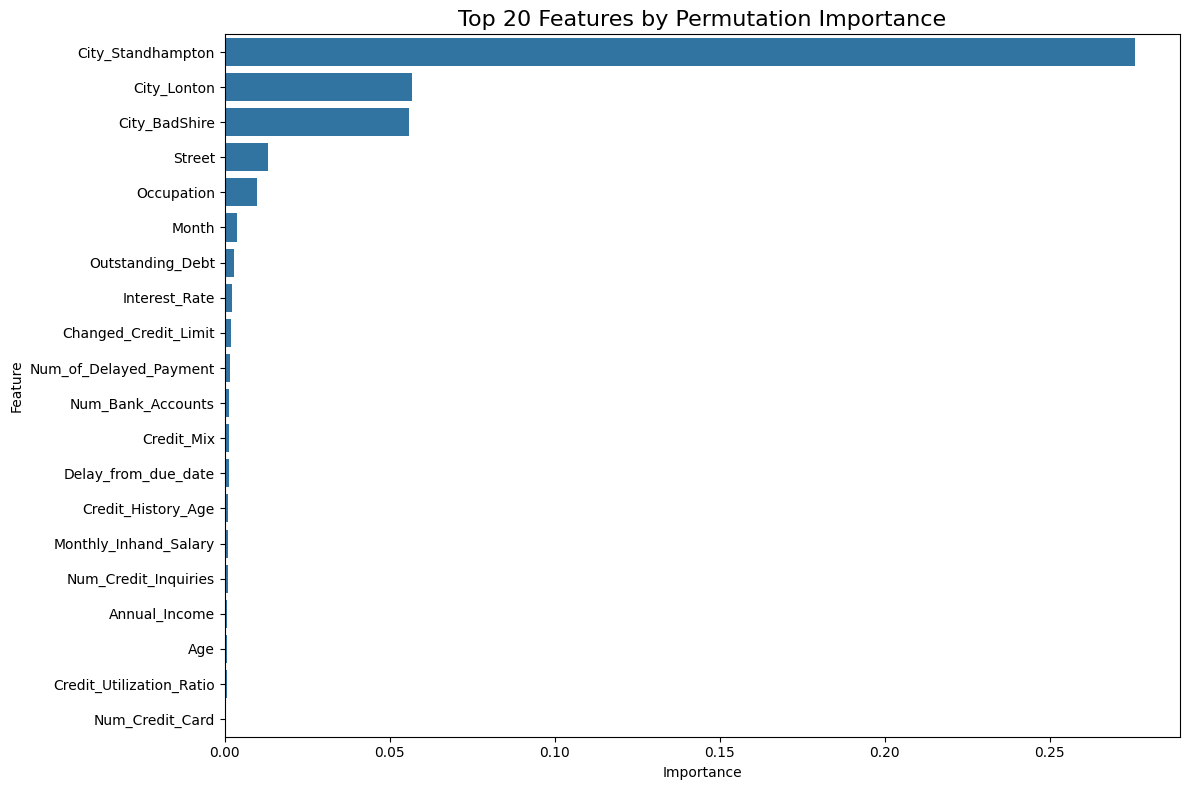

Top 15 features by permutation importance:
  1. City_Standhampton: 0.2758
  2. City_Lonton: 0.0567
  3. City_BadShire: 0.0558
  4. Street: 0.0131
  5. Occupation: 0.0097
  6. Month: 0.0036
  7. Outstanding_Debt: 0.0030
  8. Interest_Rate: 0.0023
  9. Changed_Credit_Limit: 0.0020
  10. Num_of_Delayed_Payment: 0.0016
  11. Num_Bank_Accounts: 0.0014
  12. Credit_Mix: 0.0014
  13. Delay_from_due_date: 0.0012
  14. Credit_History_Age: 0.0011
  15. Monthly_Inhand_Salary: 0.0010


3. CORRELATION VS IMPORTANCE COMPARISON
--------------------------------------------------
Features with potential non-linear relationships (high importance, low correlation):
  City_Standhampton:
    - Importance: 0.2864 (normalized: 1.0000)
    - Correlation: 0.1736 (normalized: 0.2278)
    - Recommendation: Investigate non-linear relationship with target

Features with potential spurious correlations (high correlation, low importance):
  Occupation:
    - Importance: 0.0773 (normalized: 0.2699)
    - Correlation:

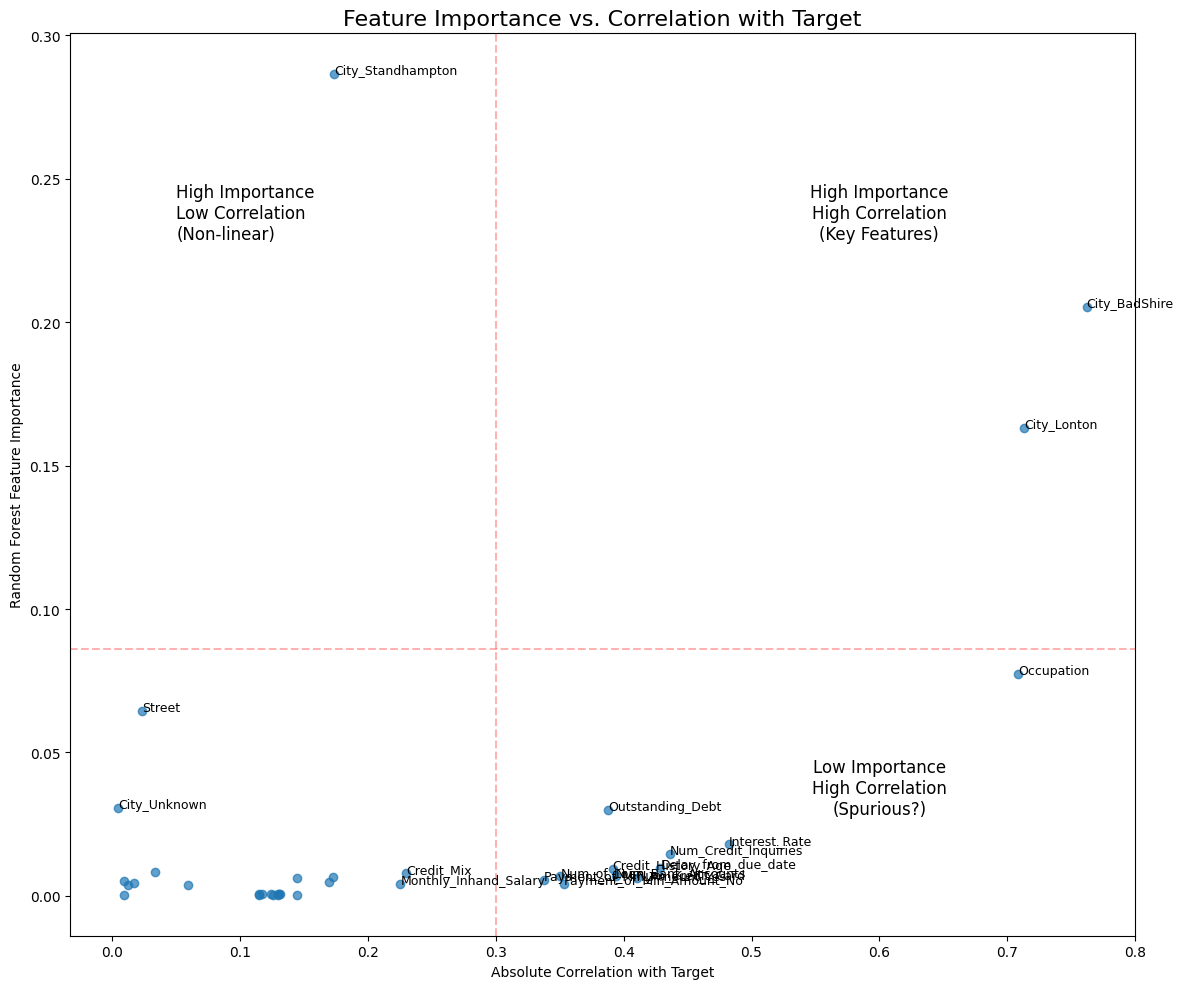



4. FINAL RECOMMENDATIONS
--------------------------------------------------
Highly recommended features (important AND correlated):
  - City_BadShire
  - City_Lonton

Recommended for non-linear relationships:
  - City_Standhampton

Final recommended feature set (3 features):
  1. City_Lonton
  2. City_Standhampton
  3. City_BadShire


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

def feature_importance_analysis(X, y, correlation_results=None, n_estimators=100, random_state=42):
    """
    Perform comprehensive feature importance analysis using multiple methods
    
    Parameters:
    -----------
    X : pandas DataFrame
        Features dataset
    y : pandas Series or array
        Target variable
    correlation_results : dict, optional
        Results from correlation_analysis function
    n_estimators : int, default=100
        Number of trees for ensemble models
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    dict
        Dictionary containing the analysis results
    """
    print("=" * 80)
    print("FEATURE IMPORTANCE ANALYSIS REPORT")
    print("=" * 80)
    
    # Store results
    results = {}
    
    # 1. Random Forest Importance
    print("\n1. RANDOM FOREST IMPORTANCE")
    print("-" * 50)
    
    # Train Random Forest model
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)
    
    # Get feature importances
    rf_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    results['rf_importances'] = rf_importances
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_importances.head(20))
    plt.title('Top 20 Features by Random Forest Importance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Analyze importance distribution
    importance_values = rf_importances['Importance'].values
    
    # Find "cliff" using gradient
    gradients = np.diff(importance_values)
    normalized_gradients = gradients / importance_values[:-1]  # Normalize by importance value
    
    # Find significant drops (cliffs)
    cliff_threshold = np.percentile(normalized_gradients, 10)  # Bottom 10% steepest drops
    cliff_indices = np.where(normalized_gradients <= cliff_threshold)[0]
    
    # Identify the most significant cliff in the top half of features
    top_half_limit = len(importance_values) // 2
    top_cliff_indices = [idx for idx in cliff_indices if idx < top_half_limit]
    
    if top_cliff_indices:
        cliff_index = top_cliff_indices[0]  # First major cliff
        cliff_value = importance_values[cliff_index]
        
        # Features above the cliff
        top_features = rf_importances.iloc[:cliff_index+1]['Feature'].tolist()
        
        print(f"Identified importance 'cliff' after feature #{cliff_index+1}: {rf_importances.iloc[cliff_index]['Feature']}")
        print(f"Importance value at cliff: {cliff_value:.4f}")
        print(f"Recommended feature count: {cliff_index+1}")
        print("\nTop features above the cliff:")
        for i, feature in enumerate(top_features):
            print(f"  {i+1}. {feature} (Importance: {rf_importances[rf_importances['Feature'] == feature]['Importance'].values[0]:.4f})")
        
        results['cliff_index'] = cliff_index
        results['top_features'] = top_features
    else:
        # If no clear cliff, use the elbow method
        from sklearn.cluster import KMeans
        from kneed import KneeLocator
        
        # Use KneeLocator to find the elbow point
        x = np.arange(len(importance_values))
        kneedle = KneeLocator(x, importance_values, curve='convex', direction='decreasing')
        elbow_index = kneedle.elbow
        
        if elbow_index is not None:
            elbow_value = importance_values[elbow_index]
            top_features = rf_importances.iloc[:elbow_index+1]['Feature'].tolist()
            
            print(f"No clear cliff found, using elbow method: feature #{elbow_index+1}: {rf_importances.iloc[elbow_index]['Feature']}")
            print(f"Importance value at elbow: {elbow_value:.4f}")
            print(f"Recommended feature count: {elbow_index+1}")
            print("\nTop features above the elbow:")
            for i, feature in enumerate(top_features):
                print(f"  {i+1}. {feature} (Importance: {rf_importances[rf_importances['Feature'] == feature]['Importance'].values[0]:.4f})")
            
            results['cliff_index'] = elbow_index
            results['top_features'] = top_features
        else:
            # If even elbow method fails, use top 15 features
            n_features = 15
            top_features = rf_importances.iloc[:n_features]['Feature'].tolist()
            
            print(f"No clear pattern in importance drop-off, using top {n_features} features")
            print("\nTop features:")
            for i, feature in enumerate(top_features):
                print(f"  {i+1}. {feature} (Importance: {rf_importances[rf_importances['Feature'] == feature]['Importance'].values[0]:.4f})")
            
            results['cliff_index'] = n_features - 1
            results['top_features'] = top_features
    
    # 2. Permutation Importance
    print("\n\n2. PERMUTATION IMPORTANCE (more robust)")
    print("-" * 50)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(rf, X, y, n_repeats=10, random_state=random_state)
    
    # Create DataFrame
    perm_imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    results['perm_importances'] = perm_imp_df
    
    # Plot permutation importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=perm_imp_df.head(20))
    plt.title('Top 20 Features by Permutation Importance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print top permutation importance features
    print("Top 15 features by permutation importance:")
    for i, (feature, importance) in enumerate(zip(perm_imp_df['Feature'].head(15), perm_imp_df['Importance'].head(15))):
        print(f"  {i+1}. {feature}: {importance:.4f}")
    
    # 3. Compare with correlation results
    if correlation_results is not None:
        target_correlation = correlation_results['target_correlation']
        
        print("\n\n3. CORRELATION VS IMPORTANCE COMPARISON")
        print("-" * 50)
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame({
            'Feature': X.columns,
            'RF_Importance': [rf_importances[rf_importances['Feature'] == f]['Importance'].values[0] 
                              if f in rf_importances['Feature'].values else 0 for f in X.columns],
            'Perm_Importance': [perm_imp_df[perm_imp_df['Feature'] == f]['Importance'].values[0] 
                               if f in perm_imp_df['Feature'].values else 0 for f in X.columns],
            'Correlation': [target_correlation[f] if f in target_correlation.index else 0 for f in X.columns]
        })
        
        # Normalize to make scales comparable
        comparison_df['RF_Importance_Norm'] = comparison_df['RF_Importance'] / comparison_df['RF_Importance'].max()
        comparison_df['Perm_Importance_Norm'] = comparison_df['Perm_Importance'] / comparison_df['Perm_Importance'].max()
        comparison_df['Correlation_Abs'] = abs(comparison_df['Correlation'])
        comparison_df['Correlation_Norm'] = comparison_df['Correlation_Abs'] / comparison_df['Correlation_Abs'].max()
        
        # Calculate difference between importance and correlation
        comparison_df['Importance_Corr_Diff'] = comparison_df['RF_Importance_Norm'] - comparison_df['Correlation_Norm']
        
        # Sort by absolute difference to find the most discrepant features
        discrepant_features = comparison_df.sort_values('Importance_Corr_Diff', key=abs, ascending=False)
        
        # Identify non-linear relationships (high importance, low correlation)
        non_linear_threshold = 0.3  # Significant difference threshold
        non_linear_features = comparison_df[
            (comparison_df['RF_Importance_Norm'] > comparison_df['Correlation_Norm'] + non_linear_threshold) & 
            (comparison_df['RF_Importance_Norm'] > 0.3)  # Only consider reasonably important features
        ]
        
        # Identify spurious correlations (high correlation, low importance)
        spurious_threshold = 0.3  # Significant difference threshold
        spurious_features = comparison_df[
            (comparison_df['Correlation_Norm'] > comparison_df['RF_Importance_Norm'] + spurious_threshold) & 
            (comparison_df['Correlation_Norm'] > 0.3)  # Only consider reasonably correlated features
        ]
        
        # Identify consistently important features (high in both metrics)
        consistently_important = comparison_df[
            (comparison_df['RF_Importance_Norm'] > 0.5) & 
            (comparison_df['Correlation_Norm'] > 0.5)
        ]
        
        # Print results
        print("Features with potential non-linear relationships (high importance, low correlation):")
        if len(non_linear_features) > 0:
            for i, row in non_linear_features.iterrows():
                print(f"  {row['Feature']}:")
                print(f"    - Importance: {row['RF_Importance']:.4f} (normalized: {row['RF_Importance_Norm']:.4f})")
                print(f"    - Correlation: {row['Correlation']:.4f} (normalized: {row['Correlation_Norm']:.4f})")
                print(f"    - Recommendation: Investigate non-linear relationship with target")
        else:
            print("  None found")
            
        print("\nFeatures with potential spurious correlations (high correlation, low importance):")
        if len(spurious_features) > 0:
            for i, row in spurious_features.iterrows():
                print(f"  {row['Feature']}:")
                print(f"    - Importance: {row['RF_Importance']:.4f} (normalized: {row['RF_Importance_Norm']:.4f})")
                print(f"    - Correlation: {row['Correlation']:.4f} (normalized: {row['Correlation_Norm']:.4f})")
                print(f"    - Recommendation: Consider if correlation is coincidental")
        else:
            print("  None found")
            
        print("\nConsistently important features (high importance AND high correlation):")
        if len(consistently_important) > 0:
            for i, row in consistently_important.iterrows():
                print(f"  {row['Feature']}:")
                print(f"    - Importance: {row['RF_Importance']:.4f} (normalized: {row['RF_Importance_Norm']:.4f})")
                print(f"    - Correlation: {row['Correlation']:.4f} (normalized: {row['Correlation_Norm']:.4f})")
                print(f"    - Recommendation: Keep as key predictor")
        else:
            print("  None found")
        
        # Create a scatter plot comparing importance vs correlation
        plt.figure(figsize=(12, 10))
        plt.scatter(comparison_df['Correlation_Abs'], comparison_df['RF_Importance'], alpha=0.7)
        
        # Add feature labels to the plot
        for i, row in comparison_df.iterrows():
            if (row['RF_Importance'] > 0.01) or (abs(row['Correlation']) > 0.2):  # Only label significant points
                plt.annotate(row['Feature'], 
                            (row['Correlation_Abs'], row['RF_Importance']),
                            fontsize=9)
        
        # Draw quadrant lines
        plt.axhline(y=comparison_df['RF_Importance'].max() * 0.3, color='r', linestyle='--', alpha=0.3)
        plt.axvline(x=0.3, color='r', linestyle='--', alpha=0.3)
        
        # Add quadrant labels
        plt.text(0.05, comparison_df['RF_Importance'].max() * 0.8, "High Importance\nLow Correlation\n(Non-linear)", 
                fontsize=12, ha='left')
        plt.text(0.6, comparison_df['RF_Importance'].max() * 0.8, "High Importance\nHigh Correlation\n(Key Features)", 
                fontsize=12, ha='center')
        plt.text(0.6, comparison_df['RF_Importance'].max() * 0.1, "Low Importance\nHigh Correlation\n(Spurious?)", 
                fontsize=12, ha='center')
        
        plt.xlabel('Absolute Correlation with Target')
        plt.ylabel('Random Forest Feature Importance')
        plt.title('Feature Importance vs. Correlation with Target', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        results['comparison'] = comparison_df
        results['non_linear_features'] = non_linear_features
        results['spurious_features'] = spurious_features
        results['consistently_important'] = consistently_important
    
    # Generate final recommendations
    print("\n\n4. FINAL RECOMMENDATIONS")
    print("-" * 50)
    
    if correlation_results is not None:
        # Combine information from both analyses
        recommended_features = set()
        
        # Add consistently important features
        if len(consistently_important) > 0:
            consistently_important_features = consistently_important['Feature'].tolist()
            recommended_features.update(consistently_important_features)
            print("Highly recommended features (important AND correlated):")
            for feature in consistently_important_features:
                print(f"  - {feature}")
        
        # Add top features from importance analysis
        recommended_features.update(results['top_features'])
        
        # Add potentially non-linear features
        if len(non_linear_features) > 0:
            non_linear_feature_list = non_linear_features['Feature'].tolist()
            recommended_features.update(non_linear_feature_list)
            print("\nRecommended for non-linear relationships:")
            for feature in non_linear_feature_list:
                print(f"  - {feature}")
        
        # Final list of recommended features
        final_list = list(recommended_features)
        print(f"\nFinal recommended feature set ({len(final_list)} features):")
        for i, feature in enumerate(final_list):
            print(f"  {i+1}. {feature}")
        
        results['recommended_features'] = final_list
    else:
        # If no correlation results, just use importance
        final_list = results['top_features']
        print(f"Recommended features based on importance ({len(final_list)} features):")
        for i, feature in enumerate(final_list):
            print(f"  {i+1}. {feature}")
        
        results['recommended_features'] = final_list
    
    return results

# Usage example:

X_without_target = X_processed.drop(columns=['Credit_Score'])
importance_results = feature_importance_analysis(X_without_target, y, correlation_analysis_results)

# Statistical Analysis & Distribution Examination

STATISTICAL ANALYSIS AND DISTRIBUTION EXAMINATION

1. TARGET DISTRIBUTION ANALYSIS
--------------------------------------------------
Target variable: Credit_Score
Number of classes: 4

Class distribution:
  0: 104 (0.42%)
  1: 7,303 (29.21%)
  2: 13,203 (52.81%)
  3: 4,390 (17.56%)

Imbalance ratio (max/min): 126.95
Assessment: Extreme imbalance

Recommendations based on target distribution:
  - Use resampling techniques (SMOTE, ADASYN, etc.)
  - Consider class weights in model training
  - Use appropriate evaluation metrics (F1, AUC, etc.)


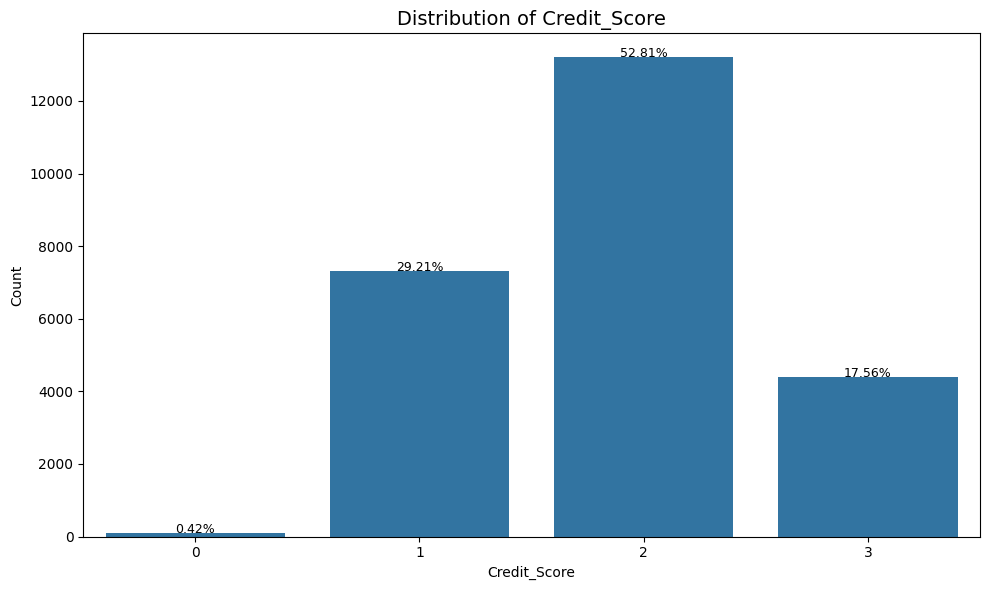



2. FEATURE DISTRIBUTION ANALYSIS
--------------------------------------------------


3. GLOBAL RECOMMENDATIONS BASED ON STATISTICAL ANALYSIS
--------------------------------------------------

Best discriminating features (keep these):

Features needing transformation:

Features with outlier issues:

Multimodal features (consider binning):


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def statistical_analysis(df, target_column, numeric_features=None, top_n=20, important_features=None):
    """
    Perform comprehensive statistical analysis and distribution examination
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset with features and target
    target_column : str
        Name of the target column
    numeric_features : list, optional
        List of numeric features to analyze. If None, all numeric features will be used
    top_n : int, default=10
        Number of features to analyze in detail if important_features is not provided
    important_features : list, optional
        List of important features identified from previous analyses
        
    Returns:
    --------
    dict
        Dictionary containing the analysis results
    """
    print("=" * 80)
    print("STATISTICAL ANALYSIS AND DISTRIBUTION EXAMINATION")
    print("=" * 80)
    
    # Initialize results
    results = {}
    
    # If numeric_features not provided, identify them
    if numeric_features is None:
        numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        if target_column in numeric_features:
            numeric_features.remove(target_column)
    
    # Determine which features to analyze in detail
    if important_features is not None:
        # Filter to keep only numeric features
        features_to_analyze = [f for f in important_features if f in numeric_features]
        if len(features_to_analyze) > top_n:
            features_to_analyze = features_to_analyze[:top_n]
    else:
        # If no important features provided, use correlation with target
        feature_correlations = df[numeric_features].corrwith(df[target_column]).abs().sort_values(ascending=False)
        features_to_analyze = feature_correlations.head(top_n).index.tolist()
    
    # 1. Target Distribution Analysis
    print("\n1. TARGET DISTRIBUTION ANALYSIS")
    print("-" * 50)
    
    # Create a copy of target column
    y = df[target_column].copy()
    
    # Check if target is numeric or categorical
    if pd.api.types.is_numeric_dtype(y):
        is_continuous_target = len(y.unique()) > 10
        if is_continuous_target:
            # For continuous target, create bins
            print("Target appears to be continuous. Creating bins for visualization.")
            y_binned = pd.cut(y, bins=5)
            target_counts = y_binned.value_counts().sort_index()
            is_classification = False
        else:
            # For discrete numeric target
            target_counts = y.value_counts().sort_index()
            is_classification = True
    else:
        # For categorical target
        target_counts = y.value_counts()
        is_classification = True
    
    # Analyze balance
    total = len(y)
    percentages = (target_counts / total * 100).round(2)
    min_class_pct = percentages.min()
    max_class_pct = percentages.max()
    imbalance_ratio = target_counts.max() / target_counts.min()
    
    # Store target distribution info
    target_dist_info = {
        'counts': target_counts,
        'percentages': percentages,
        'min_class_pct': min_class_pct,
        'max_class_pct': max_class_pct,
        'imbalance_ratio': imbalance_ratio,
        'is_classification': is_classification
    }
    results['target_distribution'] = target_dist_info
    
    # Print target distribution info
    print(f"Target variable: {target_column}")
    print(f"Number of classes: {len(target_counts)}")
    print("\nClass distribution:")
    for cls, count in target_counts.items():
        pct = percentages[cls]
        print(f"  {cls}: {count:,} ({pct}%)")
    
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    # Evaluate imbalance level
    if imbalance_ratio > 50:
        imbalance_level = "Extreme imbalance"
    elif imbalance_ratio > 10:
        imbalance_level = "High imbalance"
    elif imbalance_ratio > 3:
        imbalance_level = "Moderate imbalance"
    else:
        imbalance_level = "Relatively balanced"
    
    print(f"Assessment: {imbalance_level}")
    
    # Recommendations based on imbalance
    print("\nRecommendations based on target distribution:")
    if imbalance_ratio > 10:
        print("  - Use resampling techniques (SMOTE, ADASYN, etc.)")
        print("  - Consider class weights in model training")
        print("  - Use appropriate evaluation metrics (F1, AUC, etc.)")
    elif imbalance_ratio > 3:
        print("  - Consider class weights in model training")
        print("  - Use appropriate evaluation metrics (F1, AUC, etc.)")
    else:
        print("  - Standard modeling approaches should work well")
        print("  - Still monitor performance across all classes")
    
    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=y)
    plt.title(f'Distribution of {target_column}', fontsize=14)
    plt.xlabel(target_column)
    plt.ylabel('Count')
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.1,
                f'{percentages.iloc[i]}%',
                ha="center", fontsize=9) 
    
    plt.tight_layout()
    plt.show()
    
    # 2. Feature Distribution Analysis
    print("\n\n2. FEATURE DISTRIBUTION ANALYSIS")
    print("-" * 50)
    
    # Initialize storage for distribution results
    distribution_results = {}
    
    for feature in features_to_analyze:
        print(f"\nAnalyzing feature: {feature}")
        
        # Get feature data without NaN
        feature_data = df[feature].dropna()
        
        # Basic statistics
        min_val = feature_data.min()
        max_val = feature_data.max()
        mean_val = feature_data.mean()
        median_val = feature_data.median()
        skew_val = feature_data.skew()
        kurt_val = feature_data.kurt()
        
        print(f"  Range: {min_val:.4f} to {max_val:.4f}")
        print(f"  Central tendency: mean={mean_val:.4f}, median={median_val:.4f}")
        print(f"  Skewness: {skew_val:.4f}")
        print(f"  Kurtosis: {kurt_val:.4f}")
        
        # Test for normality
        stat, p_value = stats.shapiro(feature_data.sample(min(5000, len(feature_data)), random_state=42))
        alpha = 0.05
        normal = p_value > alpha
        
        print(f"  Normality test (Shapiro-Wilk): p-value = {p_value:.6f}")
        if normal:
            print("  Distribution: Approximately normal")
        else:
            if skew_val > 1:
                skew_direction = "right" if skew_val > 0 else "left"
                print(f"  Distribution: Significantly skewed to the {skew_direction}")
            else:
                print("  Distribution: Non-normal but not highly skewed")
        
        # Check for multimodality using kernel density estimation
        kde = stats.gaussian_kde(feature_data)
        x_vals = np.linspace(min_val, max_val, 1000)
        y_vals = kde(x_vals)
        
        # Find peaks (local maxima)
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(y_vals)
        
        multimodal = len(peaks) > 1
        if multimodal:
            print(f"  Modal pattern: Multimodal with {len(peaks)} peaks")
        else:
            print("  Modal pattern: Unimodal")
        
        # Create a figure for this feature
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Histogram with KDE
        sns.histplot(feature_data, kde=True, ax=axes[0, 0])
        axes[0, 0].set_title(f'Distribution of {feature}')
        
        # Mark peaks if multimodal
        if multimodal:
            for peak in peaks:
                axes[0, 0].axvline(x=x_vals[peak], color='r', linestyle='--', alpha=0.7)
                axes[0, 0].text(x_vals[peak], kde(x_vals[peak])+0.01, f'Peak', 
                              color='r', ha='center')
        
        # 2. Box plot
        sns.boxplot(y=feature_data, ax=axes[0, 1])
        axes[0, 1].set_title(f'Box Plot of {feature}')
        axes[0, 1].set_ylabel('')
        
        # 3. Q-Q plot
        from scipy import stats
        qq = stats.probplot(feature_data, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')
        
        # 4. Box plot by target
        if is_classification:
            sns.boxplot(x=df[target_column], y=df[feature], ax=axes[1, 1])
            axes[1, 1].set_title(f'{feature} by {target_column}')
        else:
            # For regression, use a scatter plot
            sns.scatterplot(x=df[target_column], y=df[feature], ax=axes[1, 1])
            axes[1, 1].set_title(f'{feature} vs {target_column}')
        
        plt.tight_layout()
        plt.show()
        
        # Check for outliers using IQR method
        Q1 = feature_data.quantile(0.25)
        Q3 = feature_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
        outlier_pct = len(outliers) / len(feature_data) * 100
        
        print(f"  Outliers: {len(outliers)} ({outlier_pct:.2f}% of non-null values)")
        
        # If multimodal, analyze the modes
        if multimodal:
            print("  Mode analysis:")
            for i, peak in enumerate(peaks):
                peak_x = x_vals[peak]
                print(f"    Peak {i+1}: Approximate center at {peak_x:.4f}")
        
        # Analyze feature separation by target class (if classification)
        if is_classification:
            # Calculate separation score based on distribution overlap
            class_means = df.groupby(target_column)[feature].mean()
            class_stds = df.groupby(target_column)[feature].std()
            
            # Calculate pairwise effect sizes (Cohen's d)
            effect_sizes = []
            for i, class1 in enumerate(class_means.index):
                for class2 in class_means.index[i+1:]:
                    mean1, mean2 = class_means[class1], class_means[class2]
                    std1, std2 = class_stds[class1], class_stds[class2]
                    # Pooled standard deviation
                    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
                    # Cohen's d
                    d = abs(mean1 - mean2) / pooled_std
                    effect_sizes.append(d)
            
            # Average effect size
            if effect_sizes:
                avg_effect_size = sum(effect_sizes) / len(effect_sizes)
                
                # Interpret effect size
                if avg_effect_size > 1.2:
                    separation = "Excellent separation"
                elif avg_effect_size > 0.8:
                    separation = "Good separation"
                elif avg_effect_size > 0.5:
                    separation = "Moderate separation"
                elif avg_effect_size > 0.2:
                    separation = "Weak separation"
                else:
                    separation = "Poor separation"
                
                print(f"  Target class separation: {separation} (Cohen's d = {avg_effect_size:.4f})")
            else:
                separation = "Cannot determine"
                avg_effect_size = None
                print("  Target class separation: Cannot determine (insufficient classes)")
        else:
            # For regression, use correlation
            corr = df[[feature, target_column]].corr().iloc[0, 1]
            corr_abs = abs(corr)
            
            if corr_abs > 0.7:
                separation = "Strong relationship"
            elif corr_abs > 0.4:
                separation = "Moderate relationship"
            elif corr_abs > 0.2:
                separation = "Weak relationship"
            else:
                separation = "Very weak or no linear relationship"
            
            avg_effect_size = corr_abs
            print(f"  Target relationship: {separation} (correlation = {corr:.4f})")
        
        # Provide recommendations
        print("\n  Recommendations:")
        
        # Transformation recommendation based on skewness
        if abs(skew_val) > 1:
            if skew_val > 0:  # Right-skewed
                print("    - Apply log transformation (np.log1p(x))")
            else:  # Left-skewed
                print("    - Apply square transformation (x**2)")
        
        # Outlier recommendation
        if outlier_pct > 5:
            print("    - Consider handling outliers (clipping or winsorizing)")
        
        # Multimodality recommendation
        if multimodal:
            print("    - Consider binning or creating categorical features based on the modes")
        
        # Separation recommendation
        if is_classification:
            if avg_effect_size is not None:
                if avg_effect_size < 0.2:
                    print("    - Consider dropping (poor discriminating power)")
                elif avg_effect_size < 0.5:
                    print("    - Consider feature engineering to improve separation")
                else:
                    print("    - Keep (good discriminating power)")
        else:
            if corr_abs < 0.1:
                print("    - Consider dropping (poor relationship with target)")
            elif corr_abs < 0.3:
                print("    - Consider non-linear transformations or interactions")
            else:
                print("    - Keep (good relationship with target)")
        
        # Store results for this feature
        distribution_results[feature] = {
            'basic_stats': {
                'min': min_val,
                'max': max_val,
                'mean': mean_val,
                'median': median_val,
                'skew': skew_val,
                'kurtosis': kurt_val
            },
            'normality': {
                'is_normal': normal,
                'p_value': p_value
            },
            'multimodality': {
                'is_multimodal': multimodal,
                'num_peaks': len(peaks) if multimodal else 1
            },
            'outliers': {
                'count': len(outliers),
                'percentage': outlier_pct
            },
            'target_separation': {
                'metric': 'effect_size' if is_classification else 'correlation',
                'value': avg_effect_size,
                'interpretation': separation
            }
        }
    
    results['feature_distributions'] = distribution_results
    
    # 3. Global Feature Recommendations
    print("\n\n3. GLOBAL RECOMMENDATIONS BASED ON STATISTICAL ANALYSIS")
    print("-" * 50)
    
    # Sort features by their separation power
    if is_classification:
        sorted_features = sorted(
            distribution_results.items(),
            key=lambda x: x[1]['target_separation']['value'] if x[1]['target_separation']['value'] is not None else 0,
            reverse=True
        )
    else:
        sorted_features = sorted(
            distribution_results.items(),
            key=lambda x: abs(x[1]['target_separation']['value']) if x[1]['target_separation']['value'] is not None else 0,
            reverse=True
        )
    
    # Features with good separation
    good_separators = [name for name, data in sorted_features 
                      if data['target_separation']['value'] is not None and data['target_separation']['value'] > 0.5]
    
    # Features needing transformation
    skewed_features = [name for name, data in distribution_results.items() 
                      if abs(data['basic_stats']['skew']) > 1]
    
    # Features with outlier issues
    outlier_features = [name for name, data in distribution_results.items() 
                       if data['outliers']['percentage'] > 5]
    
    # Multimodal features
    multimodal_features = [name for name, data in distribution_results.items() 
                          if data['multimodality']['is_multimodal']]
    
    # Print recommendations
    print("\nBest discriminating features (keep these):")
    for feature in good_separators:
        value = distribution_results[feature]['target_separation']['value']
        metric = "Effect size" if is_classification else "Correlation"
        print(f"  - {feature} ({metric}: {value:.4f})")
    
    print("\nFeatures needing transformation:")
    for feature in skewed_features:
        skew = distribution_results[feature]['basic_stats']['skew']
        transform = "log" if skew > 0 else "square"
        print(f"  - {feature} (Skewness: {skew:.4f}, Recommend: {transform} transform)")
    
    print("\nFeatures with outlier issues:")
    for feature in outlier_features:
        pct = distribution_results[feature]['outliers']['percentage']
        print(f"  - {feature} ({pct:.2f}% outliers)")
    
    print("\nMultimodal features (consider binning):")
    for feature in multimodal_features:
        peaks = distribution_results[feature]['multimodality']['num_peaks']
        print(f"  - {feature} ({peaks} peaks)")
    
    # Final recommended transformations
    final_transformations = {}
    
    for feature, data in distribution_results.items():
        transforms = []
        
        # Skewness transformation
        if abs(data['basic_stats']['skew']) > 1:
            if data['basic_stats']['skew'] > 0:
                transforms.append("log transformation")
            else:
                transforms.append("square transformation")
        
        # Outlier handling
        if data['outliers']['percentage'] > 5:
            transforms.append("outlier handling")
        
        # Multimodality
        if data['multimodality']['is_multimodal']:
            transforms.append("consider binning")
        
        if transforms:
            final_transformations[feature] = transforms
    
    # Save results
    results['recommended_transformations'] = final_transformations
    results['good_separators'] = good_separators
    results['skewed_features'] = skewed_features
    results['outlier_features'] = outlier_features
    results['multimodal_features'] = multimodal_features
    
    return results

# Usage example:
stats_results = statistical_analysis(X_processed, 'Credit_Score', important_features=importance_results['recommended_features'])

# Dimensionality Reduction for Visualization

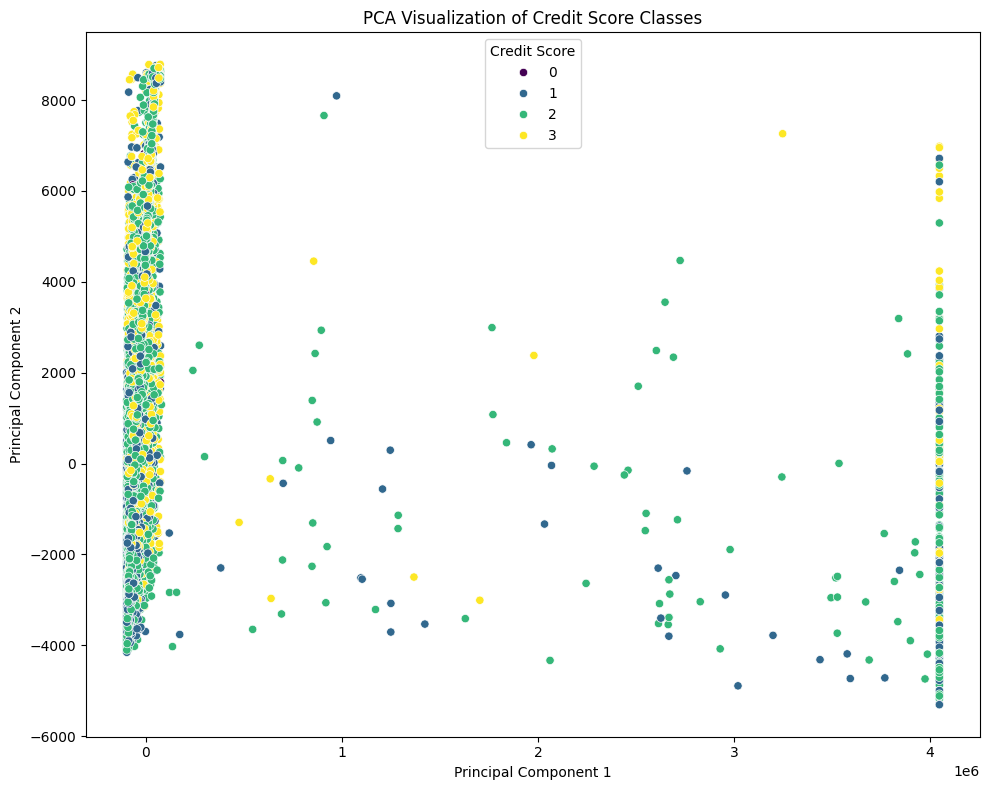

KeyboardInterrupt: 

In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_for_importance)

# Plot PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y_for_importance, palette='viridis')
plt.title('PCA Visualization of Credit Score Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Credit Score')
plt.tight_layout()
plt.show()

# t-SNE for better visualization of complex patterns
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_for_importance)

# Plot t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=y_for_importance, palette='viridis')
plt.title('t-SNE Visualization of Credit Score Classes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Credit Score')
plt.tight_layout()
plt.show()

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE

# Method 1: Correlation-based selection
correlation_threshold = 0.05  # Absolute value
correlated_features = [feature for feature, corr in 
                      target_correlation.items() if abs(corr) > correlation_threshold]
print(f"Selected {len(correlated_features)} features based on correlation")

# Method 2: Mutual information (non-linear relationships)
selector = SelectKBest(mutual_info_classif, k=20)
X_new = selector.fit_transform(X_for_importance, y_for_importance)
selected_features = X_for_importance.columns[selector.get_support()]
print(f"Selected features based on mutual information: {selected_features.tolist()}")

# Method 3: Recursive Feature Elimination
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(X_for_importance, y_for_importance)
rfe_features = X_for_importance.columns[rfe.support_]
print(f"Selected features based on RFE: {rfe_features.tolist()}")

# Get features that appear in multiple methods
feature_votes = {}
for feature in X_for_importance.columns:
    votes = 0
    if feature in correlated_features:
        votes += 1
    if feature in selected_features:
        votes += 1
    if feature in rfe_features:
        votes += 1
    feature_votes[feature] = votes

# Select features with at least 2 votes
final_selected_features = [feature for feature, votes in feature_votes.items() if votes >= 2]
print(f"\nFinal selected features ({len(final_selected_features)}):")
print(final_selected_features)

# Dataset Imbalance Analysis

In [ ]:
# Check target distribution
target_counts = y.value_counts()
print("Target distribution:")
print(target_counts)

# Calculate imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Visualize
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title(f'Target Distribution (Imbalance Ratio: {imbalance_ratio:.2f})', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()